In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv
/kaggle/input/nfl-player-contact-detection/sample_submission.csv
/kaggle/input/nfl-player-contact-detection/train_baseline_helmets.csv
/kaggle/input/nfl-player-contact-detection/test_player_tracking.csv
/kaggle/input/nfl-player-contact-detection/train_player_tracking.csv
/kaggle/input/nfl-player-contact-detection/train_video_metadata.csv
/kaggle/input/nfl-player-contact-detection/test_video_metadata.csv
/kaggle/input/nfl-player-contact-detection/train_labels.csv
/kaggle/input/nfl-player-contact-detection/test/58172_003247_All29.mp4
/kaggle/input/nfl-player-contact-detection/test/58172_003247_Sideline.mp4
/kaggle/input/nfl-player-contact-detection/test/58172_003247_Endzone.mp4
/kaggle/input/nfl-player-contact-detection/test/58168_003392_Endzone.mp4
/kaggle/input/nfl-player-contact-detection/test/58168_003392_Sideline.mp4
/kaggle/input/nfl-player-contact-detection/test/58168_003392_All29.mp4
/kaggle/input/nfl-player-con

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
# from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [3]:
train_tracking_path = "/kaggle/input/nfl-player-contact-detection/train_player_tracking.csv"
train_labels = "/kaggle/input/nfl-player-contact-detection/train_labels.csv"

In [4]:
tracking_schema = dtype = {'game_play':str,
                           'game_key':int,
                           'play_id':int,
                           'nfl_player_id':int,
                           'step':int,
                           'team':str,
                           'position':str,
                           'jersey_number':int,
                           'x_position':float,
                           'y_position':float,
                           'speed':float,
                           'distance':float,
                           'direction':float,
                           'orientation':float,
                           'acceleration':float,
                           'sa':float}

In [5]:
contact_schema = {'contact_id':str,
                  'game_play':str,
                  'step':int,
                  'nfl_player_id_1':int,
                  'nfl_player_id_2':int,
                  'contact':int}

In [6]:
class Preprocessor:
    
    def __init__(self, data_source_paths):
        self.data_source_paths = data_source_paths
        pass
    
    def read_csv(self, path, schema=None, date_col=["datetime"]):
        if schema:
            df = pd.read_csv(path, dtype=schema, parse_dates=date_col)
        else:
            df = pd.read_csv(path,parse_dates=date_col)
        return df
    
    def filter_contacts(self, df):
        df= df[df['contact']==1]
        return df.iloc[:1000,:]
    
    def remove_ground_contact(self,df):
        df.nfl_player_id_2 = pd.to_numeric(df.nfl_player_id_2.replace('G', 0))
        df['nfl_player_id_2'].drop(df[df['nfl_player_id_2'] == 0].index, inplace=True)
        return df
        
    def encode_categorical(self, df,   label_dict=None):
        df.team = df.team.replace({'home':1, 'away':-1})
        return df
    
    def join_tracking_data(self, contact_df, tracking_df):
        #fetched player 1 details
        contact_details_df = pd.merge(contact_df, tracking_df, how='inner', left_on = ['game_play', 'step', "nfl_player_id_1"], right_on = ['game_play', 'step', 'nfl_player_id'], suffixes=('','_P1'))
        selected_cols = ['contact_id', 'game_play', 'datetime', 'step', 'nfl_player_id_1',
       'nfl_player_id_2','team', 'position', 'jersey_number', 'x_position',
       'y_position', 'speed', 'distance', 'direction', 'orientation',
       'acceleration', 'sa']
        contact_details_df = contact_details_df[selected_cols]
                                      
        #fetched player 2 details
        contact_details_df = pd.merge(contact_details_df, tracking_df, how='inner', left_on = ['game_play', 'step', "nfl_player_id_2"], right_on = ['game_play', 'step', 'nfl_player_id'], suffixes=('_P1','_P2'))
        selected_cols = [
                 #     'contact_id', 'game_play', 
                 'nfl_player_id_1','nfl_player_id_2',
                #       'position_P1','position_P2','jersey_number_P1','jersey_number_P2',
                 'team_P1',  'x_position_P1', 'y_position_P1', 'speed_P1', 'distance_P1','direction_P1', 'orientation_P1', 'acceleration_P1', 'sa_P1',
                 'team_P2',  'x_position_P2', 'y_position_P2','speed_P2', 'distance_P2', 'direction_P2', 'orientation_P2','acceleration_P2', 'sa_P2']
        contact_details_df = contact_details_df[selected_cols]
        return contact_details_df
        
            

In [7]:
processor = Preprocessor([train_tracking_path,train_labels])

In [8]:
tracking_df = processor.read_csv(train_tracking_path, tracking_schema)
tracking_df.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10 21:08:20.900000+00:00,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10 21:08:20.900000+00:00,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10 21:08:20.900000+00:00,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10 21:08:20.900000+00:00,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10 21:08:20.900000+00:00,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [9]:
contact_df = processor.read_csv(train_labels)
contact_df.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11 03:01:48.100000+00:00,0,38590,47944,0


In [10]:
contact_df = processor.filter_contacts(contact_df)
# replacing 'G' with 0
contact_df = processor.remove_ground_contact(contact_df)
contact_df.shape

(1000, 7)

In [11]:
#replace home with 1 and away with -1
tracking_df= processor.encode_categorical(tracking_df)
tracking_df.shape 
#(13,53,053, 17)

(1353053, 17)

In [12]:
contact_details_df = processor.join_tracking_data( contact_df, tracking_df)
print(contact_details_df.shape )
contact_details_df.head()

(746, 20)


,nfl_player_id_1,nfl_player_id_2,team_P1,x_position_P1,y_position_P1,speed_P1,distance_P1,direction_P1,orientation_P1,acceleration_P1,sa_P1,team_P2,x_position_P2,y_position_P2,speed_P2,distance_P2,direction_P2,orientation_P2,acceleration_P2,sa_P2
0,41944,42565,-1,41.78,22.56,1.43,0.15,217.49,287.37,1.56,1.51,1,40.70,23.02,1.66,0.17,189.20,109.99,1.29,1.28
1,41944,42565,-1,41.67,22.38,1.83,0.21,212.07,288.29,1.55,1.47,1,40.68,22.85,1.80,0.18,188.04,117.12,0.84,0.84
2,37084,38567,-1,41.54,20.00,1.07,0.11,254.82,257.32,0.41,0.40,1,40.82,19.54,1.72,0.20,125.75,103.92,1.07,1.05
3,43854,46445,-1,41.49,16.61,1.23,0.12,234.00,312.29,1.08,0.37,1,40.67,17.42,1.63,0.16,155.99,114.56,0.33,0.16
4,41944,42565,-1,41.58,22.20,2.00,0.20,208.64,295.28,1.38,1.23,1,40.65,22.66,1.91,0.19,187.69,124.81,0.38,0.38


**Cheking with an example**

In [13]:
tracking_df[(tracking_df['nfl_player_id']==41944) & (tracking_df['game_play']=="58168_003392")& (tracking_df['step']==3)]

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
1081081,58168_003392,58168,3392,41944,2020-09-11 03:01:48.400000+00:00,3,-1,DT,92,41.78,22.56,1.43,0.15,217.49,287.37,1.56,1.51


In [14]:
# tracking_df[(tracking_df['nfl_player_id']==42565)].sort_values(by='datetime').iloc[185:]
tracking_df[(tracking_df['nfl_player_id']==42565) & (tracking_df['game_play']=="58168_003392")& (tracking_df['step']==3)]

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
1081085,58168_003392,58168,3392,42565,2020-09-11 03:01:48.400000+00:00,3,1,C,62,40.7,23.02,1.66,0.17,189.2,109.99,1.29,1.28


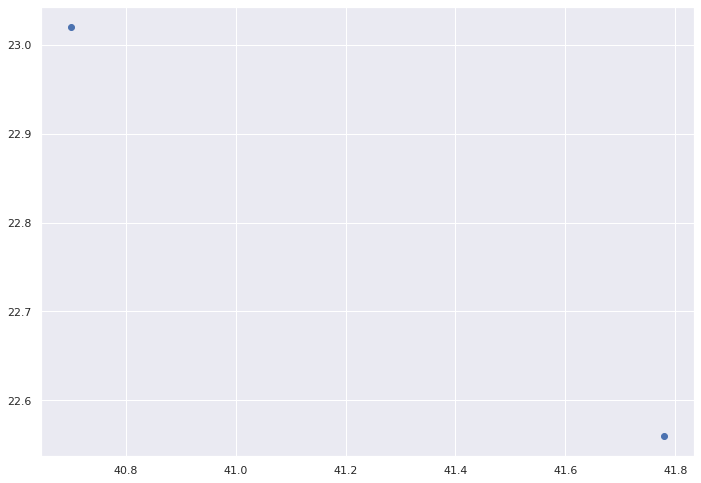

In [15]:
x = np.array([41.78,40.7 ])
y = np.array([22.56,23.02 ])

plt.scatter(x, y)
plt.show()

In [16]:
class FeatureEngineer:
    def calculate_angle_of_collision(self, x):
        theta = abs(x['orientation_P1']-x['orientation_P2'])
        return theta
    
    def calculate_torque_per_unit_mass(self, x):
        theta =x['angle_of_collision']
        torque = x['force_per_unit_mass']*x['player_sensor_distance']*math.sin(theta)
        return torque
    
    def calculate_force_per_unit_mass(self, x):
        a_x = x['acceleration_P1']*math.cos(x['orientation_P1']) - x['acceleration_P2']*math.cos(x['orientation_P2'])
        a_y = x['acceleration_P1']*math.sin(x['orientation_P1']) - x['acceleration_P2']*math.sin(x['orientation_P2'])
        return math.sqrt((a_x**2)+(a_y**2))
    
    def calculate_relative_valocity(self, x):
        v_x = x['speed_P1']*math.cos(x['orientation_P1']) - x['speed_P2']*math.cos(x['orientation_P2'])
        v_y = x['speed_P1']*math.sin(x['orientation_P1']) - x['speed_P2']*math.sin(x['orientation_P2'])
        return math.sqrt((v_x**2)+(v_y**2)) 
    
    def calculate_distance(self, x):
        dx = x['x_position_P1'] - x['x_position_P2']
        dy = x['y_position_P1'] - x['y_position_P2']
        return math.sqrt((dx**2)+(dy**2)) 
    
    def get_cluster_df(self, contact_details_df):
        cluster_df = pd.DataFrame()
        cluster_df['diff_team_collision'] = (contact_details_df['team_P1']*contact_details_df['team_P2']).apply(lambda x: 1 if x==-1 else 0)
        cluster_df['relative_velocity'] = contact_details_df.apply(self.calculate_relative_valocity, axis =1)
        cluster_df['player_sensor_distance'] = contact_details_df.apply(self.calculate_distance, axis =1)
        cluster_df['force_per_unit_mass'] =contact_details_df.apply(self.calculate_force_per_unit_mass,axis=1)
        cluster_df['angle_of_collision'] = contact_details_df.apply(self.calculate_angle_of_collision,axis=1)
        cluster_df['angle_of_collision'] = cluster_df['angle_of_collision'].apply(lambda x: 360-x if x>180 else x)
        cluster_df['torque_per_unit_mass'] = abs(cluster_df.apply(self.calculate_torque_per_unit_mass,axis=1))
        return cluster_df, list(cluster_df.columns)

In [17]:
feature_engineer = FeatureEngineer()
cluster_df, cluster_cols = feature_engineer.get_cluster_df(contact_details_df)

In [18]:
cluster_df[['angle_of_collision']].describe()

,angle_of_collision
count,746.000000
mean,109.678874
std,50.966889
min,0.510000
25%,69.657500
50%,117.045000
75%,154.695000
max,179.990000


In [19]:
cluster_df.head()

,diff_team_collision,relative_velocity,player_sensor_distance,force_per_unit_mass,angle_of_collision,torque_per_unit_mass
0,1,2.057237,1.173882,1.901563,177.38,2.216163
1,1,2.506132,1.095901,1.728085,171.17,1.891737
2,1,2.695191,0.854400,1.437510,153.40,0.629401
3,1,2.847312,1.152606,1.405428,162.27,1.438356
4,1,1.567896,1.037545,1.156009,170.47,0.880208


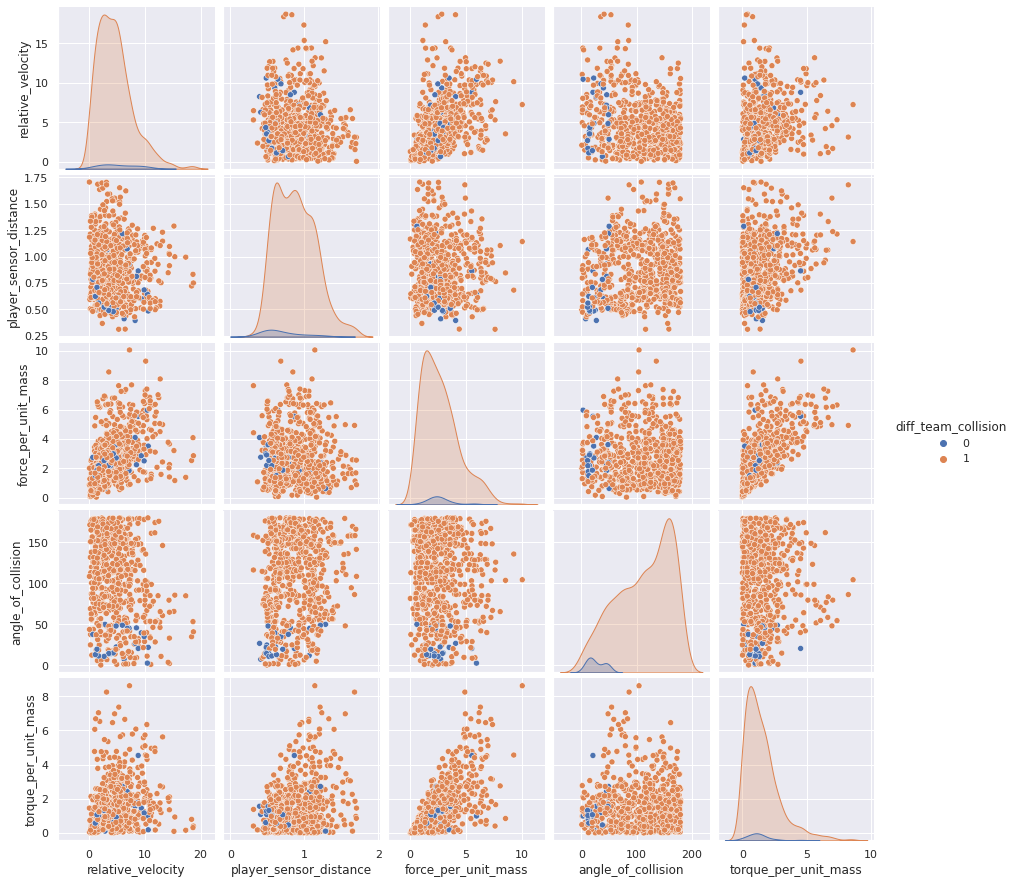

In [20]:
sns.pairplot(cluster_df, hue='diff_team_collision')

In [21]:
# plt.scatter(cluster_df['diff_team_collision'],cluster_df['player_sensor_distance'])

In [22]:
class Cluster:
    def __init__(self, df):
        self.cluster_df = df
        self.columns = list(df.columns)
        self.scaled_features=None
        self.scale()
    def scale(self):
        scaler = StandardScaler()
        self.scaled_features = scaler.fit_transform(self.cluster_df)
        self.sf_df = pd.DataFrame(self.scaled_features)
        return self.scaled_features
    def Kmeans(self, find_k=False):
        if find_k:
            kmeans_kwargs = {
                "init": "random",
                "n_init": 10,
                "max_iter": 300,
                "random_state": 42,}
            # A list holds the SSE values for each k
            sse = []
            for k in range(1, 11):
                kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
                kmeans.fit(self.scaled_features)
                sse.append(kmeans.inertia_)
            plt.style.use("fivethirtyeight")
            plt.plot(range(1, 11), sse)
            plt.xticks(range(1, 11))
            plt.xlabel("Number of Clusters")
            plt.ylabel("SSE")
            plt.show()
#             kl = KneeLocator( range(1, 11), sse, curve="convex", direction="decreasing")
#             k = kl.elbow
        else:
            kmeans = KMeans(n_clusters=3)
            kmeans.fit(self.scaled_features)
            kmeans_silhouette = silhouette_score( self.scaled_features, kmeans.labels_ ).round(2)
            print("kmeans_silhouette", kmeans_silhouette)
            df = self.cluster_df.copy()
            df['km_label'] = kmeans.labels_
            sns.scatterplot(data=df, x="force_per_unit_mass", y="angle_of_collision", hue="km_label", palette="deep")
            return kmeans.labels_, pd.DataFrame(kmeans.labels_).value_counts()
        return
            
        
    def DBScan(self,epsilon=2):
            
        dbscan = DBSCAN(eps=epsilon)
        dbscan.fit(self.scaled_features)
        df = self.cluster_df.copy()
        df['db_label'] = dbscan.labels_
        sns.scatterplot(data=df, x="force_per_unit_mass", y="angle_of_collision", hue="db_label", palette="deep")
        return dbscan.labels_, pd.DataFrame(dbscan.labels_).value_counts()
    
    def Hierarchical(self,n=2,find_n=False ):
        if find_n:
            linkage_data = linkage(self.scaled_features, method='ward', metric='euclidean')
            dendrogram(linkage_data)
            plt.show()
            return linkage_data
        else:
            hierarchical_cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
            labels = hierarchical_cluster.fit_predict(self.scaled_features)
            df = self.cluster_df.copy()
            df['h_label'] = labels
            sns.scatterplot(data=df, x="force_per_unit_mass", y="angle_of_collision", hue="h_label",style="diff_team_collision", palette="deep")
            return labels, pd.DataFrame(labels).value_counts()


In [23]:
cluster = Cluster(cluster_df)
cluster.sf_df.describe()

,0,1,2,3,4,5
count,7.460000e+02,7.460000e+02,7.460000e+02,7.460000e+02,7.460000e+02,7.460000e+02
mean,1.142964e-16,6.667291e-17,-2.190681e-16,-9.524702e-18,5.714821e-17,2.476422e-16
std,1.000671e+00,1.000671e+00,1.000671e+00,1.000671e+00,1.000671e+00,1.000671e+00
min,-5.370289e+00,-1.444158e+00,-2.071048e+00,-1.598703e+00,-2.143394e+00,-1.116907e+00
25%,1.862097e-01,-7.359887e-01,-8.546592e-01,-7.786695e-01,-7.857695e-01,-7.133738e-01
50%,1.862097e-01,-1.315162e-01,-7.065430e-02,-1.953870e-01,1.446246e-01,-2.404385e-01
75%,1.862097e-01,5.232024e-01,7.364789e-01,5.447980e-01,8.838351e-01,3.824191e-01
max,1.862097e-01,4.443712e+00,3.070976e+00,4.377113e+00,1.380471e+00,5.193872e+00


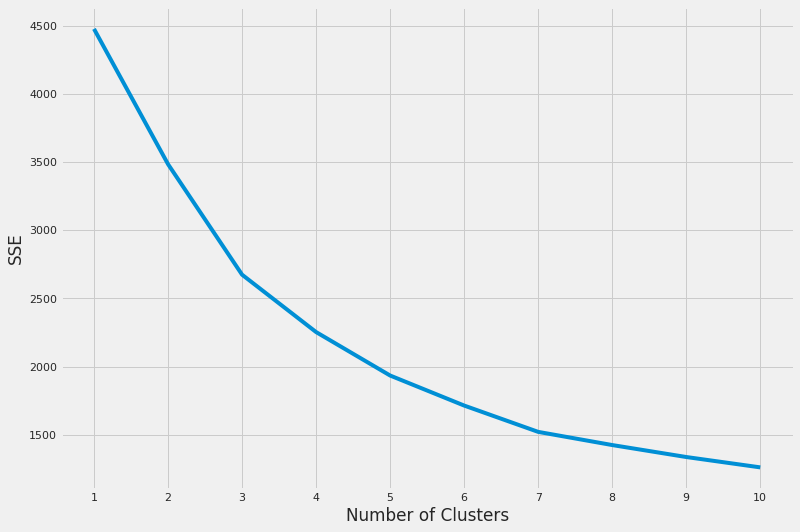

In [24]:
cluster.Kmeans(True)

kmeans_silhouette 0.31


2    499
1    222
0     25
dtype: int64

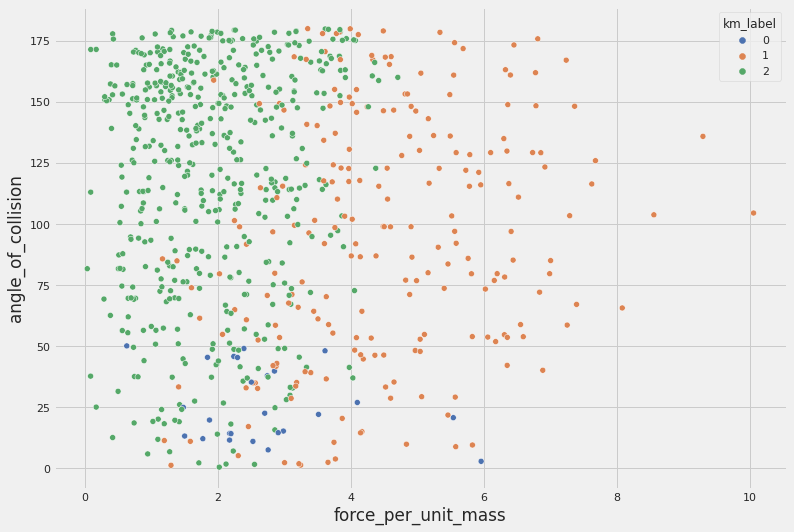

In [25]:
kmlabels, kmcount_freq = cluster.Kmeans()
kmcount_freq

0    746
dtype: int64

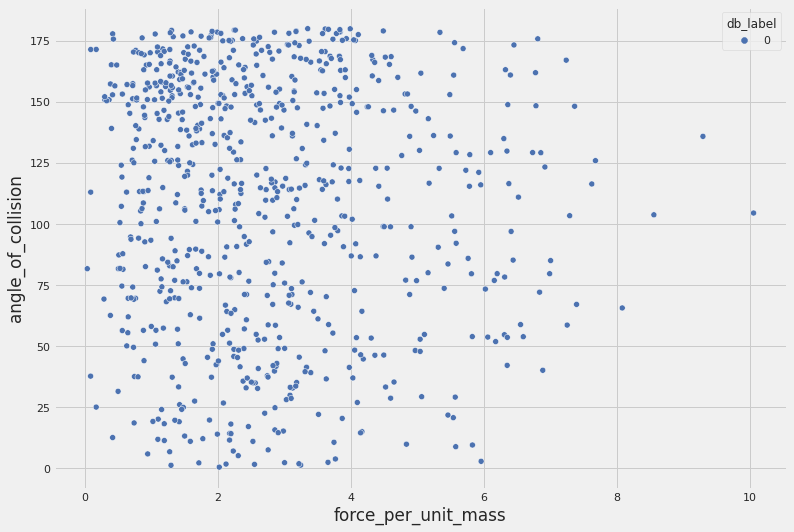

In [26]:
dblabels, dbcount_freq = cluster.DBScan(100)
dbcount_freq

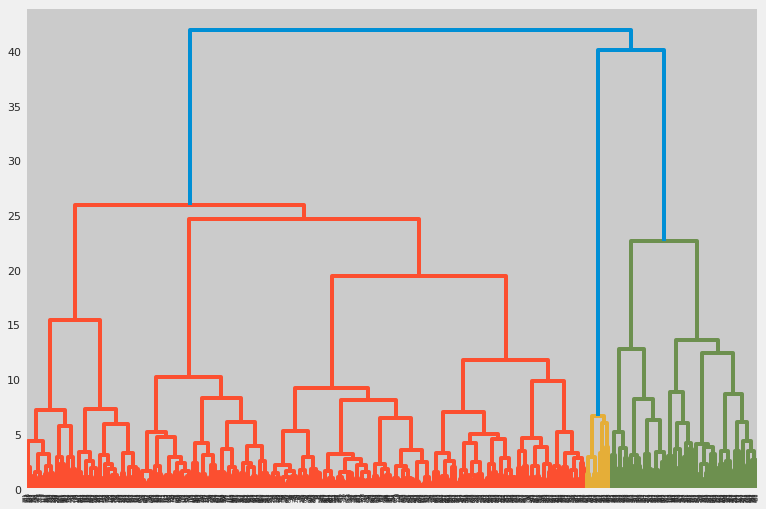

In [27]:
hdata = cluster.Hierarchical(find_n=True)

0    572
1    149
2     25
dtype: int64

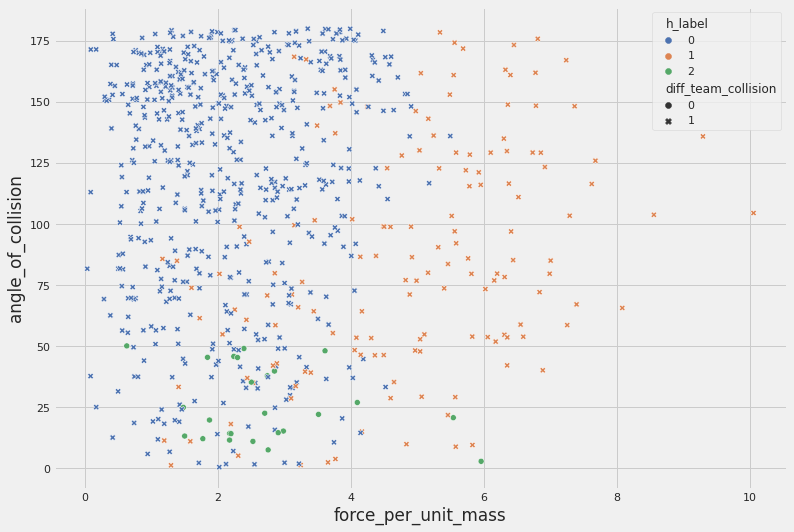

In [28]:
hlabel, hfreq = cluster.Hierarchical(n=3)
hfreq